# NLPGroup5: Comparing Pre-Trained Models’ Performance on QQA

### Part 1: Setting up for Evaluation
To get started, we are importing all the necessary libraries to perform our evaluations.

In [2]:
#Collecting all imports
from datasets import load_dataset, load_metric
from transformers import AutoTokenizer, pipeline, AutoModelForQuestionAnswering
from dataclasses import dataclass
from typing import Optional, Union
import numpy as np
import json
from evaluate import load
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt 

### Part 2: Loading the Dataset


Now we are loading our dataset in from our JSON files and manipulating to fit our evaluation process. See the README for where to find these dataset files from the NumEval @ SemEval 2024 site.

In [3]:
datasets = load_dataset("json", data_files={'Project/QQA_Data/QQA_train.json', 
                                           'Project/QQA_Data/QQA_dev.json', 
                                           'Project/QQA_Data/QQA_test.json'})

print(len(datasets["train"]))
print(datasets["train"])

807
Dataset({
    features: ['question_sci_10E_char', 'Option1', 'answer', 'question_mask', 'question_char', 'type', 'question', 'Option2', 'question_sci_10E'],
    num_rows: 807
})


Our dataset has 807 items, where [].

Each item contains a number of questions in different formats, two options, and an answer. For example, the following is an item from the dataset's "train" file:

{
    "question": "Lyle takes his jeep to the beach. When he drives it on the concrete, the jeep moves at a speed of 39 km/hr on average. When Lyle drives the jeep on the sand, it moves at a speed of 28 km/hr. The concrete has? ",
    
    "Option1": "less resistance", 
    
    "Option2": "more resistance.",
    
    "answer": "Option 1", 
    
    "type": "Type_3", 

    "question_sci_10E": "Lyle takes his jeep to the beach. When he drives it on the concrete, the jeep moves at a speed of 3.9000000000E+01 km/hr on average. When Lyle drives the jeep on the sand, it moves at a speed of 2.8000000000E+01 km/hr. The concrete has? ", 
    
    "question_char": "Lyle takes his jeep to the beach. When he drives it on the concrete, the jeep moves at a speed of 3 9 km/hr on average. When Lyle drives the jeep on the sand, it moves at a speed of 2 8 km/hr. The concrete has? ", 
    
    "question_sci_10E_char": "Lyle takes his jeep to the beach. When he drives it on the concrete, the jeep moves at a speed of 3 . 9 0 0 0 0 0 0 0 0 0 E + 0 1 km/hr on average. When Lyle drives the jeep on the sand, it moves at a speed of 2 . 8 0 0 0 0 0 0 0 0 0 E + 0 1 km/hr. The concrete has? ", 
    
    "question_mask": "Lyle takes his jeep to the beach. When he drives it on the concrete, the jeep moves at a speed of [Num] km/hr on average. When Lyle drives the jeep on the sand, it moves at a speed of [Num] km/hr. The concrete has? "
    }

We will drop the other formats for brevity and only use the "question" part of the dataset as the question.

In the dataset, it's important to note that the model can't "cheat" using other information. For example, in the following question:

A race car and a pickup both drove on the highway at the same speed. The driver of the race car got tired and parked after 29 mins, while the driver of the pickup ran for 43 mins. Which vehicle ultimately went the greater distance?? 

The model may think that "race car" is similar to "fast" and would travel faster, but the speeds have been equalized and only time matters. In fact, in the above question, the pickup travels further! The model needs to understand the differences in time traveled, specifically that the pickup has been traveling for longer, to answer the question correctly. 

In [4]:
#Here we are dropping unnecessary columns for brevity
datasets = datasets.remove_columns(['question_char', 'question_sci_10E',
                         'question_sci_10E_char',
                         'question_mask', 'type',])

### Part 3: Evaluation Function and Variable Initialization
Here we are defining our evaluation function. Here we set up our pretrained models for question answering and tokenize using an AutoTokenizer. We are also using a question answering pipeline from Huggingface using our model and tokenizer. We manipulate our dataset to fit the expected format of our pipeline. We then generate predictions using the pipeline and append those along with our references (correct answers). Finally we compute our comparison metrics (exact match) and print those.

We are evaluating our models on "Exact Match" from Huggingface. Essentially we want our model to be <u>completely</u> accurate or else our predicted answers do not count

In [5]:
exact_match = load("exact_match")

In [6]:
#Intitializng our model name variable and performance list
model_name = ''
modelPerformanceList = []
modelNames = []

def evaluate_hf_model(model_name, dataset):
    global modelPerformance
    model = AutoModelForQuestionAnswering.from_pretrained(model_name)       # Initialize the model
    tokenizer = AutoTokenizer.from_pretrained(model_name)                   # Initialize the tokenizer
    
    #initialize our pipeline with our input model
    processor = pipeline('question-answering', model=model, tokenizer=tokenizer)
    
    #format our dataset
    def dataset_generator(dataset):
        for ex in dataset:
            #Here we clean the option answer to use later for "context"
            cleansedAnswer = ex['answer'].replace(" ", "")
            yield (ex,
                {'question' : ex['question'], 'context': ex[cleansedAnswer]})
    #initialize predictions and references lists        
    predictions = []
    references = []

    # Get predictions
    for ex in tqdm(dataset_generator(datasets[dataset]), total=len(datasets[dataset])):
        predictions.append(processor(ex[1])['answer'])

        #Appending our answer which will be our reference
        references.append(ex[0][ex[0]['answer'].replace(" ", "")])

    # Compute metrics
    modelPerformance = exact_match.compute(predictions=predictions, references=references)
    print('Performance of {} : {}'.format(model_name, modelPerformance))

In [61]:
def evaluate_hf_model(model_name, dataset):
    global modelPerformance
    model = AutoModelForQuestionAnswering.from_pretrained(model_name)       # Initialize the model
    tokenizer = AutoTokenizer.from_pretrained(model_name)                   # Initialize the tokenizer
    
    #initialize our pipeline with our input model
    processor = pipeline('question-answering', model=model, tokenizer=tokenizer)
    
    #format our dataset
    def dataset_generator(dataset):
        for ex in dataset:
            #Here we clean the option answer to use later for "context"
            cleansedAnswer = ex['answer'].replace(" ", "")
            #print(ex[cleansedAnswer])
            questionFrag = ex['question'].split('.')
            questionJoin = ''.join(questionFrag[:-1])

            yield (ex,
                {'question' : questionJoin, 'context': questionFrag[-1]})
    #initialize predictions and references lists        
    predictions = []
    references = []

    # Get predictions
    for ex in tqdm(dataset_generator(datasets[dataset]), total=len(datasets[dataset])):
        predictions.append(processor(ex[1])['answer'])
        #Appending our answer which will be our reference
        references.append(ex[0][ex[0]['answer'].replace(" ", "")])

        #print(processor(ex[1])['answer'])

    # Compute metrics
    modelPerformance = exact_match.compute(predictions=predictions, references=references)
    print('Performance of {} : {}'.format(model_name, modelPerformance))

In [ ]:
datasetEval = 'train'

model_name = 'bert-base-uncased'
evaluate_hf_model(model_name, datasetEval)

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/807 [00:00<?, ?it/s]

### Part 4: Evaluation
In this section we are evaluating performances for our models on our dataset. Since all data is part of the "train" split, we will evaluate on the "train" split of our dataset.

#### Baseline Models
Here we are evaluating our "Baseline" models like BERT

In [6]:
#We are evaluating on our "train" dataset in this section
datasetEval = 'train'

model_name = 'bert-base-uncased'
evaluate_hf_model(model_name, datasetEval)
modelNames.append(model_name)
modelPerformanceList.append(modelPerformance)
print('{} performance saved: {}'.format(model_name, modelPerformance))

model_name = 'distilbert/distilbert-base-uncased'
evaluate_hf_model(model_name, datasetEval)
modelNames.append(model_name)
modelPerformanceList.append(modelPerformance)
print('{} performance saved: {}'.format(model_name, modelPerformance))

model_name = 'dccuchile/bert-base-spanish-wwm-cased'
evaluate_hf_model(model_name, datasetEval)
modelNames.append(model_name)
modelPerformanceList.append(modelPerformance)
print('{} performance saved: {}'.format(model_name, modelPerformance))

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/807 [00:00<?, ?it/s]

Performance of bert-base-uncased : {'exact_match': 0.5006195786864932}
bert-base-uncased performance saved: {'exact_match': 0.5006195786864932}


Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/807 [00:00<?, ?it/s]

Performance of distilbert/distilbert-base-uncased : {'exact_match': 0.5080545229244114}
distilbert/distilbert-base-uncased performance saved: {'exact_match': 0.5080545229244114}


Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/807 [00:00<?, ?it/s]

Performance of dccuchile/bert-base-spanish-wwm-cased : {'exact_match': 0.6084262701363073}
dccuchile/bert-base-spanish-wwm-cased performance saved: {'exact_match': 0.6084262701363073}


#### SQuAD Models
Here we are evaluating our "SQuAD" models like RoBERTa and Dynamic TinyBERT

In [7]:
#We are evaluating on our "train" dataset in this section
datasetEval = 'train'

model_name = 'deepset/roberta-base-squad2'
evaluate_hf_model(model_name, datasetEval)
modelNames.append(model_name)
modelPerformanceList.append(modelPerformance)
print('{} performance saved: {}'.format(model_name, modelPerformance))

model_name = 'Intel/dynamic_tinybert'
evaluate_hf_model(model_name, datasetEval)
modelNames.append(model_name)
modelPerformanceList.append(modelPerformance)
print('{} performance saved: {}'.format(model_name, modelPerformance))

model_name = 'distilbert/distilbert-base-cased-distilled-squad'
evaluate_hf_model(model_name, datasetEval)
modelNames.append(model_name)
modelPerformanceList.append(modelPerformance)
print('{} performance saved: {}'.format(model_name, modelPerformance))

model_name = 'FabianWillner/distilbert-base-uncased-finetuned-squad'
evaluate_hf_model(model_name, datasetEval)
modelNames.append(model_name)
modelPerformanceList.append(modelPerformance)
print('{} performance saved: {}'.format(model_name, modelPerformance))

  0%|          | 0/807 [00:00<?, ?it/s]

Performance of deepset/roberta-base-squad2 : {'exact_match': 0.7942998760842627}
deepset/roberta-base-squad2 performance saved: {'exact_match': 0.7942998760842627}


  0%|          | 0/807 [00:00<?, ?it/s]

Performance of Intel/dynamic_tinybert : {'exact_match': 0.7633209417596035}
Intel/dynamic_tinybert performance saved: {'exact_match': 0.7633209417596035}


  0%|          | 0/807 [00:00<?, ?it/s]

Performance of distilbert/distilbert-base-cased-distilled-squad : {'exact_match': 0.8029739776951673}
distilbert/distilbert-base-cased-distilled-squad performance saved: {'exact_match': 0.8029739776951673}


  0%|          | 0/807 [00:00<?, ?it/s]

Performance of FabianWillner/distilbert-base-uncased-finetuned-squad : {'exact_match': 0.8475836431226765}
FabianWillner/distilbert-base-uncased-finetuned-squad performance saved: {'exact_match': 0.8475836431226765}


#### Sentiment Analysis Models
Here we are evaluating our "Sentiment Analysis" models like ...

In [8]:
model_name = 'siebert/sentiment-roberta-large-english'
evaluate_hf_model(model_name, datasetEval)
modelNames.append(model_name)
modelPerformanceList.append(modelPerformance)
print('{} performance saved: {}'.format(model_name, modelPerformance))

model_name = 'MilaNLProc/feel-it-italian-sentiment'
evaluate_hf_model(model_name, datasetEval)
modelNames.append(model_name)
modelPerformanceList.append(modelPerformance)
print('{} performance saved: {}'.format(model_name, modelPerformance))

model_name = 'DT12the/distilbert-sentiment-analysis'
evaluate_hf_model(model_name, datasetEval)
modelNames.append(model_name)
modelPerformanceList.append(modelPerformance)
print('{} performance saved: {}'.format(model_name, modelPerformance))

model_name = 'abhilash1910/financial_roberta'
evaluate_hf_model(model_name, datasetEval)
modelNames.append(model_name)
modelPerformanceList.append(modelPerformance)
print('{} performance saved: {}'.format(model_name, modelPerformance))

Some weights of RobertaForQuestionAnswering were not initialized from the model checkpoint at siebert/sentiment-roberta-large-english and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/807 [00:00<?, ?it/s]

Performance of siebert/sentiment-roberta-large-english : {'exact_match': 0.5464684014869888}
siebert/sentiment-roberta-large-english performance saved: {'exact_match': 0.5464684014869888}


Some weights of CamembertForQuestionAnswering were not initialized from the model checkpoint at MilaNLProc/feel-it-italian-sentiment and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/807 [00:00<?, ?it/s]

Performance of MilaNLProc/feel-it-italian-sentiment : {'exact_match': 0.6071871127633209}
MilaNLProc/feel-it-italian-sentiment performance saved: {'exact_match': 0.6071871127633209}


Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at DT12the/distilbert-sentiment-analysis and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/807 [00:00<?, ?it/s]

Performance of DT12the/distilbert-sentiment-analysis : {'exact_match': 0.6022304832713755}
DT12the/distilbert-sentiment-analysis performance saved: {'exact_match': 0.6022304832713755}


Some weights of RobertaForQuestionAnswering were not initialized from the model checkpoint at abhilash1910/financial_roberta and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/807 [00:00<?, ?it/s]

Performance of abhilash1910/financial_roberta : {'exact_match': 0.5477075588599752}
abhilash1910/financial_roberta performance saved: {'exact_match': 0.5477075588599752}


### Part 5: Results Visualization
In this section we will be graphing based on model type and dataset.

#### Baseline Model Visualization

['bert-base-uncased', 'distilbert/distilbert-base-uncased', 'dccuchile/bert-base-spanish-wwm-cased', 'deepset/roberta-base-squad2', 'Intel/dynamic_tinybert', 'distilbert/distilbert-base-cased-distilled-squad', 'FabianWillner/distilbert-base-uncased-finetuned-squad', 'siebert/sentiment-roberta-large-english', 'MilaNLProc/feel-it-italian-sentiment', 'DT12the/distilbert-sentiment-analysis', 'abhilash1910/financial_roberta']


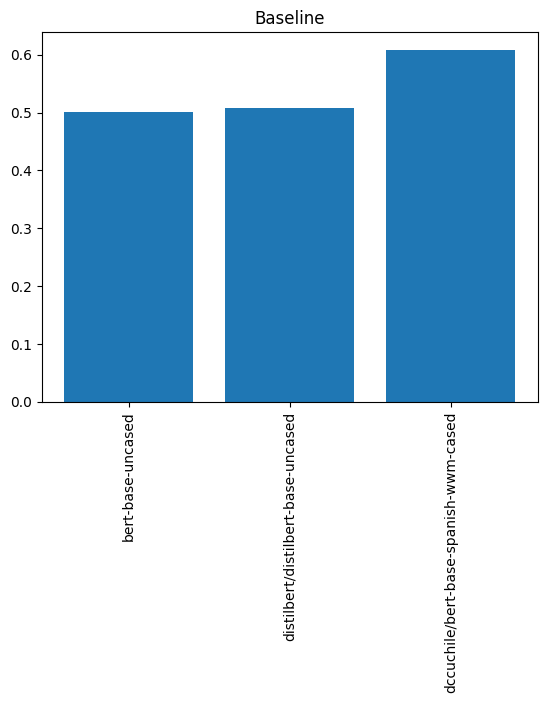

In [9]:
xpoints = np.linspace(1, len(modelNames), len(modelNames))

print(modelNames)
#list(modelPerformanceList.values())

valsList = [x['exact_match'] for x in modelPerformanceList]


#Set plot and plot
plt.title("Baseline")
plt.xticks(xpoints[0:3], modelNames[0:3], rotation = 'vertical')
plt.bar(xpoints[0:3], valsList[0:3])
plt.show()

#### SQuAD Model Visualization

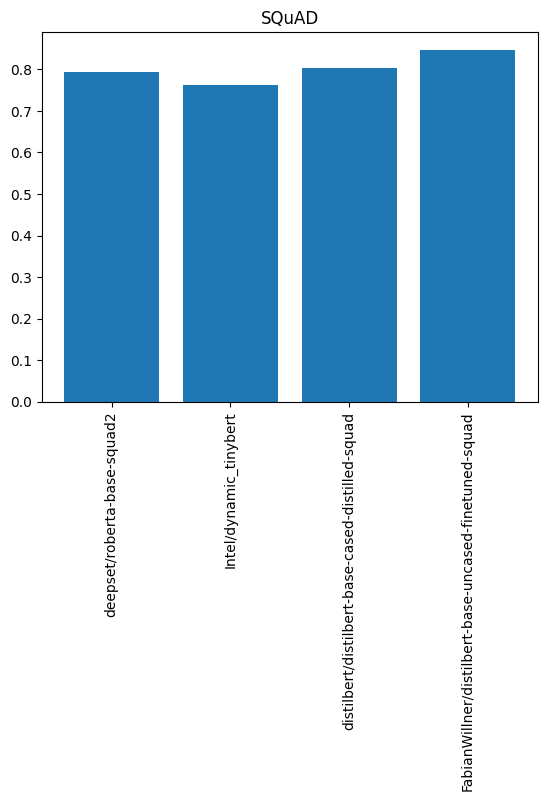

In [10]:
#Set plot and plot
plt.title("SQuAD")
plt.xticks(xpoints[3:7], modelNames[3:7], rotation = 'vertical')
plt.bar(xpoints[3:7], valsList[3:7])
plt.show()

#### Sentiment Analysis Model Visualization

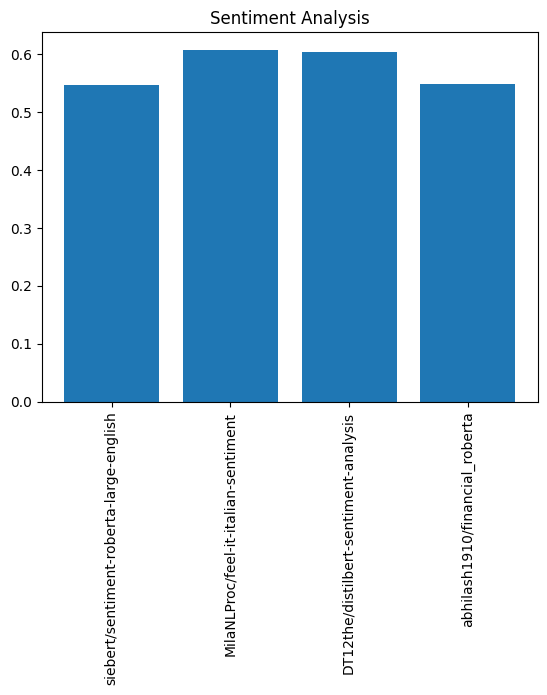

In [11]:
#Set plot and plot
plt.title("Sentiment Analysis")
plt.xticks(xpoints[7:11], modelNames[7:11], rotation = 'vertical')
plt.bar(xpoints[7:11], valsList[7:11])
plt.show()

#### Combined Visualization

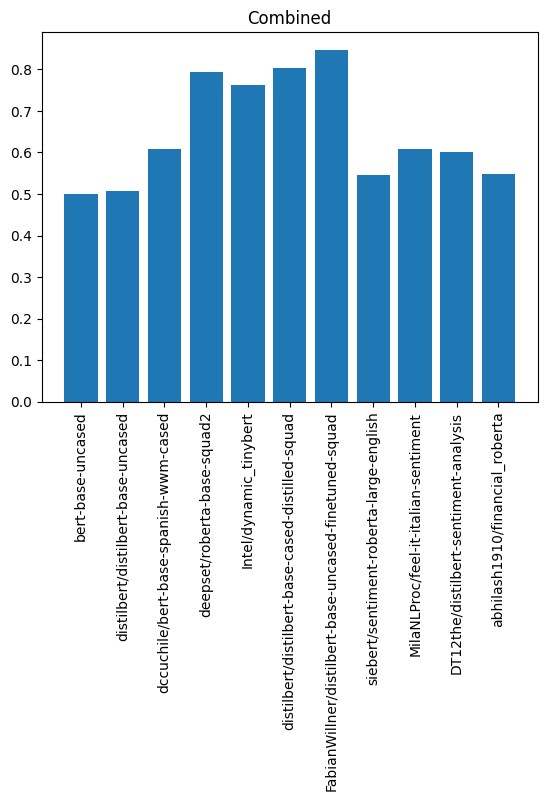

In [12]:
plt.title("Combined")
plt.xticks(xpoints, modelNames, rotation = 'vertical')
plt.bar(xpoints, valsList)
plt.show()

### Part 6: Conclusion and Analysis

Our results...